# Phase analysis

In [1]:
import os
import time
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import pandas as pd
from sklearn.metrics import mean_squared_error

#from wavelets.wave_python.waveletFunctions import *
import itertools
from scipy.fftpack import fft
from collections import defaultdict,Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib import cm, ticker
import scipy.io as sio
from IPython.display import display
import scipy.stats
import datetime as dt
from sklearn.ensemble import GradientBoostingClassifier
import scipy.signal as sgn
from scipy.integrate import simpson
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter


from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import EngFormatter

from analysis_functions import *
from test_functions import *

#from wavelets.wave_python.waveletFunctions import *
print('Loaded')

2025-02-26 22:31:09.365907: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 22:31:09.369864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 22:31:09.385337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 22:31:09.411164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 22:31:09.417665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 22:31:10.831349: W tensorflow/compiler/tf2tensorrt/utils/p

[(13636.363636363636, 20454.54545454545), (22727.272727272724, 27272.727272727272), (4545.454545454545, 20454.54545454545), (122727.27272727272, 127272.72727272726), (163636.36363636362, 170454.54545454544), (34090.90909090909, 45454.54545454545), (20454.54545454545, 45454.54545454545), (79545.45454545454, 86363.63636363635), (247727.2727272727, 252272.72727272724), (20454.54545454545, 56818.181818181816), (61363.63636363636, 70454.54545454544), (190909.09090909088, 220454.54545454544), (111363.63636363635, 145454.54545454544), (288636.3636363636, 293181.8181818182)]
Loaded


In [2]:
data_dir = "../../data/"
suffixes = [f"{i:03d}" for i in range(170)]

sufix = 1
sample = 2  #0 - 9999
fs = 25e6  #sample_frequency
dt = 1/25e6 #period

samples = load_samples(data_dir,f"{sufix:03d}")

# Obtain I[0] and Q[1] signals
i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]

# Calculate the magnitude and phase of the IQ signal
mag = np.sqrt(q_signal**2 + i_signal**2)
phase = np.arctan2(q_signal, i_signal)

iq_signal = np.array(i_signal + 1J*q_signal, dtype=complex)

print('Done')

Done


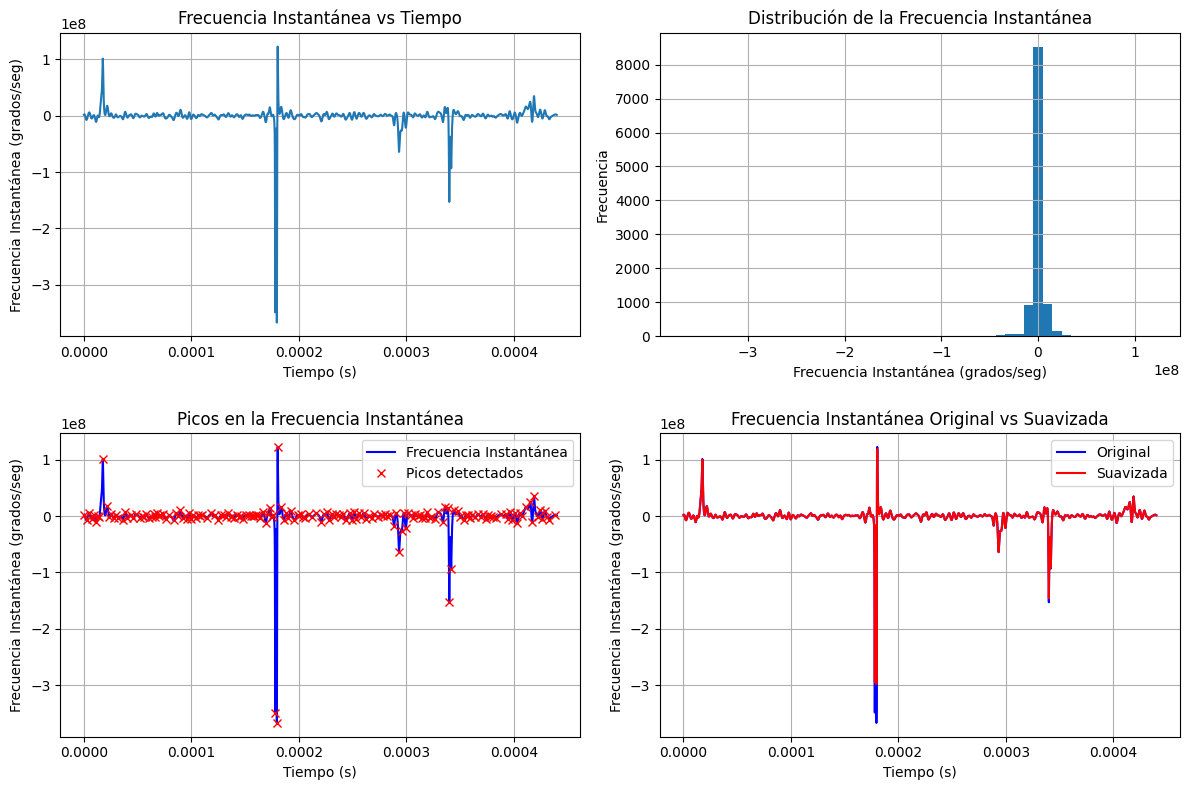

Media: -413545.53 grados/seg
Desviación estándar: 17257442.00 grados/seg


In [5]:
t = np.arange(len(phase)) / fs  # Time in seconds
phase_unwrapped = np.unwrap(phase)
phase_diff = savgol_filter(phase_unwrapped, window_length=11, polyorder=2, deriv=1, delta=dt)
instantaneous_frequency_deg = phase_diff * (180 / np.pi)

# a) Gráfica temporal básica
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(t, instantaneous_frequency_deg)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia Instantánea (grados/seg)')
plt.title('Frecuencia Instantánea vs Tiempo')
plt.grid(True)

# b) Histograma
plt.subplot(2, 2, 2)
plt.hist(instantaneous_frequency_deg, bins=50)
plt.xlabel('Frecuencia Instantánea (grados/seg)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Frecuencia Instantánea')
plt.grid(True)

# c) Detección de picos
peaks, _ = find_peaks(np.abs(instantaneous_frequency_deg), height=10, distance=10)
plt.subplot(2, 2, 3)
plt.plot(t, instantaneous_frequency_deg, 'b-', label='Frecuencia Instantánea')
plt.plot(t[peaks], instantaneous_frequency_deg[peaks], "x", color='red', label='Picos detectados')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia Instantánea (grados/seg)')
plt.title('Picos en la Frecuencia Instantánea')
plt.legend()
plt.grid(True)

# d) Suavizado
smoothed_freq = savgol_filter(instantaneous_frequency_deg, window_length=21, polyorder=2)
plt.subplot(2, 2, 4)
plt.plot(t, instantaneous_frequency_deg, 'b-', label='Original')
plt.plot(t, smoothed_freq, 'r-', label='Suavizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia Instantánea (grados/seg)')
plt.title('Frecuencia Instantánea Original vs Suavizada')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# e) Estadísticas
print(f"Media: {np.mean(instantaneous_frequency_deg):.2f} grados/seg")
print(f"Desviación estándar: {np.std(instantaneous_frequency_deg):.2f} grados/seg")

Correlación temporal o autocorrelación

Calcula la autocorrelación de la frecuencia instantánea para identificar periodicidades o patrones repetitivos:

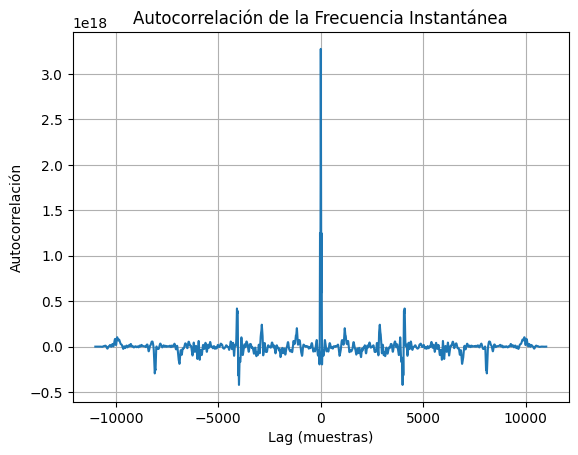

In [6]:
from scipy.signal import correlate

autocorrelation = correlate(instantaneous_frequency_deg - np.mean(instantaneous_frequency_deg), 
                           instantaneous_frequency_deg - np.mean(instantaneous_frequency_deg), 
                           mode='full')
lags = np.arange(-len(instantaneous_frequency_deg) + 1, len(instantaneous_frequency_deg))
plt.plot(lags, autocorrelation)
plt.xlabel('Lag (muestras)')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la Frecuencia Instantánea')
plt.grid(True)
plt.show()